# Automatic Ticket Classification Case Study
<hr style="border:0.2px solid gray"> </hr>

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. we can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [1]:
pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Libraries for data loading, Exploratory data visualization
import swifter
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

# Libraries for text preprocessing and analysis
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
from collections import Counter

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
complaintsFile = open('/content/drive/MyDrive/Automatic-Ticket-Classification-main/Automatic-Ticket-Classification-main/complaints-2021-05-14_08_16.json')
complaintsData = json.load(complaintsFile)
#To read the data in dataframe
df=pd.json_normalize(complaintsData)

## Data preparation

**Let's explore data using Data table display for Pandas dataframes**

In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df.rename(columns={'_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint_what_happened', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [6]:
# To display dataframe in form of interactive data table
from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab.data_table import DataTable
DataTable.max_columns = 25

In [8]:

df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
df = df[['complaint_what_happened', 'product']]
df.head(50)

,complaint_what_happened,product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card
5,,Checking or savings account
6,,Checking or savings account
7,,Mortgage
8,,Checking or savings account
9,,Checking or savings account


In [11]:
# Remove rows where complaint what happend is blank
df = df[df['complaint_what_happened'].astype(bool)]
df.head(10)

,complaint_what_happened,product
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account
15,Can you please remove inquiry,"Credit reporting, credit repair services, or o..."
17,With out notice J.P. Morgan Chase restricted m...,Checking or savings account
20,"During the summer months, I experience a decli...",Vehicle loan or lease
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","Money transfer, virtual currency, or money ser..."
23,I have a Chase credit card which is incorrectl...,Credit card or prepaid card


## Prepare the text for topic modeling

After removing blank complaints:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


After all the cleaning operations, performed the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
import re
# Function to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
  # Make the text lowercase
  text = text.lower()

  # Remove text in square brackets
  text = re.sub('\[.*?\]', '', text)

  # Remove punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

  # Remove words containing numbers
  text = re.sub('\w*\d\w*', '', text)

  # Remove text within curly braces
  text = re.sub('\{.*?\}', '', text)

  # Remove line breaks
  text = text.replace('\n', ' ')

  # Remove date
  text = re.sub('\d{4}-\d{2}-\d{2}', '', text)

 # Remove xxx characters 
  text = re.sub(r'xx+', '',text) 

  # Remove unnecessary white spaces
  text = re.sub(' +', ' ', text)


  return text


In [13]:
# test above function
text = 'This is some [sample] text with punctuation and numbers like 1, 2, 3 and dates like 2020-12-31 and xxxx-xxxx xx. It also contains text within {curly braces} and line breaks.\n'
clean_text = preprocess_text(text)
print(clean_text)

this is some text with punctuation and numbers like and dates like and it also contains text within curly braces and line breaks 


After all the cleaning operations, performed the following:

Lemmatize the texts
Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [14]:
# Function to Lemmatize the texts
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Apply data cleaning**

In [15]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaint_what_happened'].apply(preprocess_text)
df.head()

,complaint_what_happened,product,complaints
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,i upgraded my card in and was told by the agen...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,my grand son give me check for i deposit it in...


In [16]:
df['lemmatized'] = df['complaints'].swifter.apply(lemmatization)
df.head()

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

,complaint_what_happened,product,complaints,lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = df[['complaints','lemmatized']]

In [18]:
df_clean.head()

,complaints,lemmatized
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [19]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for token in doc:
         # Filter only tokens which are Noun
        if(token.tag_ == 'NN'):
            nn_words.append(token.lemma_)
    # return string of tokens        
    nn_words_str = " ".join(nn_words)
    return nn_words_str


swifter library is used here for prallal operations on dataframe, resulting in faster processing

In [20]:

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(20)

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
15,can you please remove inquiry,can you please remove inquiry,inquiry
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice chase account debit card branch custome...
20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer month decline income employment month p...
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue


## Exploratory data analysis to get familiar with the data.

Data visulaisation:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




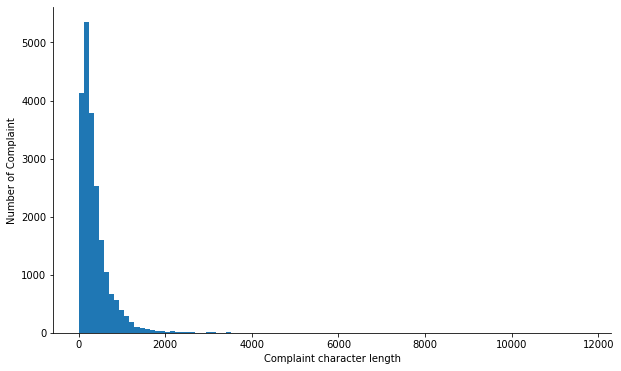

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

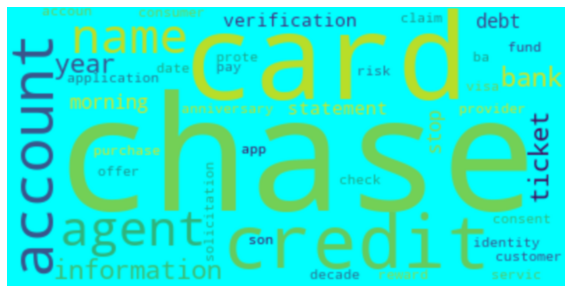

In [23]:
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS),background_color='cyan')
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head(5)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...


In [25]:
#Removing -Chase- from the text corpus

# df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('chase', '')
# df_clean.head(5)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [36]:
# def top_ngrams(grams,n=40):
#     #Find ngram
#     c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
#     ngrams = c_vec.fit_transform(df_clean['Complaint_clean'])
#     #Count occurances of a ngram
#     count_values =ngrams.toarray().sum(axis=0)
#     # # get ngram vocabulary
#     vocab = c_vec.vocabulary_

#     # # get count of respective to vocab and after sorting create a dataframe
#     #df_ngram = pd.DataFrame([(count_values[i],k) for k,i in vocab.items()]).rename(columns={0: 'frequency', 1:'ngram'})
   
#     # return dataframe
#     return vocab
    
    

In [26]:
from collections import Counter
from nltk.util import ngrams
full_sent = ''
for i in df_clean["Complaint_clean"]:
  full_sent+=i+' '
allWords = nltk.tokenize.word_tokenize(full_sent)


In [32]:
unigrams = ngrams(allWords,1)
pd.DataFrame(Counter(unigrams).most_common(30))


,0,1
0,"(chase,)",64857
1,"(account,)",47229
2,"(credit,)",32667
3,"(card,)",30358
4,"(payment,)",21161
5,"(bank,)",18578
6,"(time,)",16033
7,"(day,)",12979
8,"(charge,)",12071
9,"(money,)",11959


In [47]:
bigrams = ngrams(allWords,2)
bigram_df=pd.DataFrame(Counter(bigrams).most_common(30))
bigram_df

,0,1
0,"(credit, card)",12868
1,"(account, chase)",3991
2,"(credit, report)",3877
3,"(chase, credit)",3788
4,"(checking, account)",3498
5,"(chase, bank)",3173
6,"(chase, account)",3162
7,"(customer, service)",3037
8,"(account, account)",2674
9,"(bank, account)",2272


In [34]:
trigrams = ngrams(allWords,3)
pd.DataFrame(Counter(trigrams).most_common(30))

,0,1
0,"(chase, credit, card)",2603
1,"(credit, card, account)",1080
2,"(credit, card, company)",999
3,"(credit, card, chase)",941
4,"(chase, customer, service)",613
5,"(inquiry, credit, report)",559
6,"(credit, card, credit)",551
7,"(chase, checking, account)",517
8,"(account, credit, card)",482
9,"(card, credit, card)",449


In [60]:
df_clean.head(5)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [108]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [109]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])
dtm
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aa,aaaratings,aarp,ab,aba,aback,abandon,abandoned,abandonment,abate,...,zero,zeroed,zeros,zilch,zip,zipcode,zombie,zone,zones,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
tfidf.get_feature_names()

['aa',
 'aaaratings',
 'aarp',
 'ab',
 'aba',
 'aback',
 'abandon',
 'abandoned',
 'abandonment',
 'abate',
 'abatement',
 'abbreviation',
 'abd',
 'aberrant',
 'abet',
 'abetted',
 'abetting',
 'abhorrent',
 'abide',
 'abided',
 'abiding',
 'abilities',
 'ability',
 'able',
 'abnormal',
 'abnormally',
 'abou',
 'abovementioned',
 'abovenamed',
 'abovereferenced',
 'abrasive',
 'abreast',
 'abroad',
 'abrupt',
 'abruptly',
 'abs',
 'absconding',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absolutly',
 'absolve',
 'absorb',
 'absorbed',
 'absurd',
 'absurdity',
 'absurdly',
 'abundance',
 'abundantly',
 'abuse',
 'abused',
 'abuser',
 'abuses',
 'abusing',
 'abusive',
 'abusively',
 'abysmal',
 'ac',
 'academic',
 'acc',
 'acccount',
 'acccounts',
 'accelerate',
 'accelerated',
 'accelerating',
 'acceleration',
 'accent',
 'accents',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepteddenied',
 'accepting',
 'accepts',
 'access',
 'accessed',
 'accesses',
 'accessib

In [111]:
len(tfidf.get_feature_names())

15710

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we will perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [112]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [113]:
#Load your nmf_model with the n_components i.e 5
N_TOPICS = 5
#keep the random_state =40
nmf = NMF(random_state=40, n_components=N_TOPICS)

In [114]:
W=nmf.fit(dtm) #Document Topic Matrix
H=nmf.components_# Topic Term Matrix


In [115]:
#Print the Top15 words for each of the topics
#get feature names as words
words = np.array(tfidf.get_feature_names())

#initialize df for Topic and corresponding 15 word
topic_words_df = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,called,fraud,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,removed,debt
Topic 3,loan,mortgage,chase,home,modification,property,payments,foreclosure,house,bank,years,jp,morgan,sale,rate
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,fee,month,fees,statement,account,charged,chase,monthly,make


In [116]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [117]:
#Assign the best topic to each of the complaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [118]:
df_clean.head(10)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice chase account debit card branch custome...,notice chase account debit card branch custome...,3
20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,4
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,1


In [120]:
# Print the first 5 Complaint for each of the Topics
topic_df=df_clean[['complaints','Topic']].groupby('Topic').head(5)
topic_df.sort_values('Topic')

,complaints,Topic
2,i upgraded my card in and was told by the agen...,0
21,on i made a payment to an online retailer usin...,0
43,chase sent me an email today with the innocuou...,0
40,a sofa love seat table and chairs and was nev...,0
32,my chase amazon card was declined for a cateri...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
15,can you please remove inquiry,1
23,i have a chase credit card which is incorrectl...,1
26,i have reached out to several times in attempt...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [121]:
# Create the dictionary of Topic names and Topics
Topics = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topics)

In [122]:
df_clean.head(5)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Account Services
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,Others
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

We have built a model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.

*Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)*

In [123]:
# Create the dictionary again of Topic names and Topics

Topics = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topics)

In [124]:
df_clean.head(5)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3


In [125]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints','Topic']]

In [126]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit for yrs ive had cha...,4


#### Applying the supervised models on the training data created. In this process, we are going to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [128]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,confusion_matrix

In [130]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

**1. Logistic Regression**

In [131]:
# Logistic Regression
lr = LogisticRegression(random_state=42,solver='sag')
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)


In [132]:
print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1194
           1       0.96      0.95      0.95      1103
           2       0.97      0.95      0.96       923
           3       0.93      0.97      0.95      1400
           4       0.96      0.88      0.92       648

    accuracy                           0.95      5268
   macro avg       0.95      0.94      0.95      5268
weighted avg       0.95      0.95      0.95      5268



In [133]:
print(confusion_matrix(y_test, y_pred=predicted))

[[1143   17    1   33    0]
 [  27 1046    8   10   12]
 [  13    8  874   21    7]
 [  22    7    5 1361    5]
 [  16   12   16   31  573]]


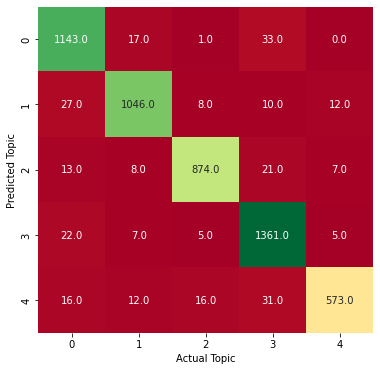

In [134]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual Topic")
plt.ylabel("Predicted Topic")
plt.show()

**2. Decision Tree**

In [135]:
# Decision tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1194
           1       0.79      0.79      0.79      1103
           2       0.82      0.82      0.82       923
           3       0.78      0.82      0.80      1400
           4       0.71      0.67      0.69       648

    accuracy                           0.77      5268
   macro avg       0.77      0.76      0.76      5268
weighted avg       0.77      0.77      0.77      5268



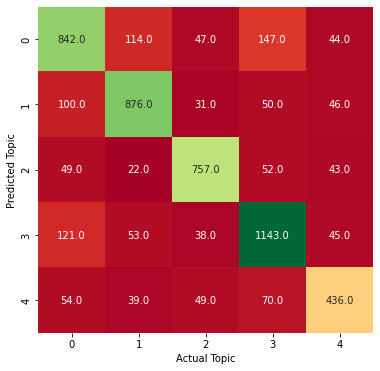

In [136]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual Topic")
plt.ylabel("Predicted Topic")
plt.show()

**3. Random Forest Classifier**

In [139]:
rfc = RandomForestClassifier(max_depth=50)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1194
           1       0.83      0.85      0.84      1103
           2       0.90      0.89      0.89       923
           3       0.77      0.95      0.85      1400
           4       0.93      0.52      0.66       648

    accuracy                           0.83      5268
   macro avg       0.86      0.80      0.82      5268
weighted avg       0.84      0.83      0.83      5268



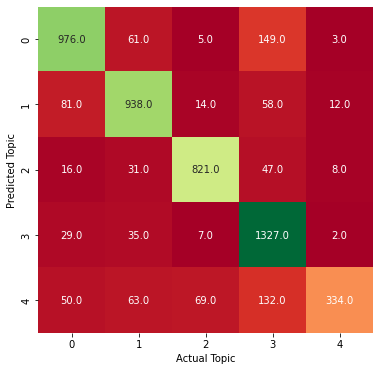

In [140]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual Topic")
plt.ylabel("Predicted Topic")
plt.show()

**4. Gaussian Naive Bayes**

In [141]:
nb = GaussianNB()
nb.fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43      1194
           1       0.35      0.29      0.32      1103
           2       0.53      0.50      0.52       923
           3       0.45      0.29      0.36      1400
           4       0.19      0.50      0.28       648

    accuracy                           0.37      5268
   macro avg       0.41      0.39      0.38      5268
weighted avg       0.42      0.37      0.38      5268



**Clearly Logistic Regression is performing better**

### Infering the best model

In [142]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I am not happy with my credit card interest rate.", 
                                  "I have just received a statement of this account. It contains charges for purchases I have not made.",
                                  "I bought a new car. I paid the loan  but chase financial never release the title I contacted chase several time with no resolution each time they told me they will release it but nothing was done now i moved to another state and i can not get the registration in the other state because i do not have the title i will be obliged to rent a car since i can not use my car.",
                                  "summer month decline income employment month payment extension auto loan company chase past year request payment extension auto loan payment request month payment extension year situation supervisor avail discussion reason decline reason denial office director representative chase week representative office representative role matter representative conference call department request information request policy change explanation representative letter explanation letter reason denial wa policy change cfpb help denial payment extension request reason denial",
                                  "What is the procedure to know my CIBIL score?",
                                  "	to whom it may concern chase bank charged wrongly overdraft fees i have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but chase always changed the order and charged me overdraft fee anyway when you call they said their per their guidelines they dont refund more then overdrawft doesnt matter bank fault or not taken from people is money just because you can is not ok see attached documents when chase refund they always find the way to take back what they refunded in first place"]})
df_complaints

,complaints
0,I am not happy with my credit card interest rate.
1,I have just received a statement of this accou...
2,I bought a new car. I paid the loan but chase...
3,summer month decline income employment month p...
4,What is the procedure to know my CIBIL score?
5,\tto whom it may concern chase bank charged wr...


In [143]:
def predict_lr(text):
    Topics = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topics[predicted[0]]

In [144]:
df_complaints['Ticket_Category'] = df_complaints['complaints'].apply(lambda c: predict_lr([c]))
df_complaints

,complaints,Ticket_Category
0,I am not happy with my credit card interest rate.,Others
1,I have just received a statement of this accou...,Account Services
2,I bought a new car. I paid the loan but chase...,Mortgage/Loan
3,summer month decline income employment month p...,Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,\tto whom it may concern chase bank charged wr...,Theft/Dispute Reporting


## Conclusion
    
* **As expected 5 topics were indetified namely:**
    1. Account Services
    2. Others
    3. Mortgage/Loan
    4. Credit card or prepaid card
    5. Theft/Dispute Reporting
    
    
* **Tried 4 models on the data with accuracies as follows:**

    | Model       | Accuracy |
    | ----------- | ----------- |
    | Logistic Regression      | 0.95       |
    | Decision Tree   | 0.77        |
    | Random Forest      | 0.74       |
    | Naive Bayes   | 0.36        |
    
 <br /> <br /> <br /> <br /><br /> <br /><br />
* **Logistic Regression has highest accuracy of `0.95`, Hence is a good fit for this particular case study.**